In [1]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn import decomposition
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, trj_3d

from record_0_main import smlt_ma

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

STRAINS = ['NM91', 'ZH23']
STRAIN_KEY = '_'.join(STRAINS).lower()

FSTRAIN = 'data/simple/strains.csv'
MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

In [2]:
# record activity on the fly
df_behav = pd.read_csv('data/simple/c_song_f_behav.csv')  # load songs
df_trs = [df_behav[df_behav.ID == i] for i in ISTRAIN]
df_behav = None

In [3]:
N = 20

rtau_r = [20, 60]
rtau_a = [.1, 2]

tau_rs = np.random.uniform(*rtau_r, N)
tau_as = np.random.uniform(*rtau_a, N)
x_ss = np.random.uniform(0, 1, N)
x_ps = 1 - x_ss

params = {'TAU_R': tau_rs, 'TAU_A': tau_as, 'X_S': x_ss, 'X_P': x_ps}

In [4]:
rs_20_mas = []

for df_tr in df_trs:
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2

    # simulate population response
    rs_20_ma = smlt_ma(i_s, i_p, params, DT)
    sys.stdout.write('.')
    
    rs_20_mas.append(rs_20_ma)

.......................................................................................

In [5]:
pca_20 = decomposition.PCA().fit(cc(rs_20_mas, axis=0))
var_exp_ma_20 = pca_20.explained_variance_ratio_

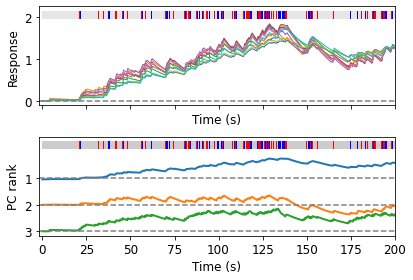

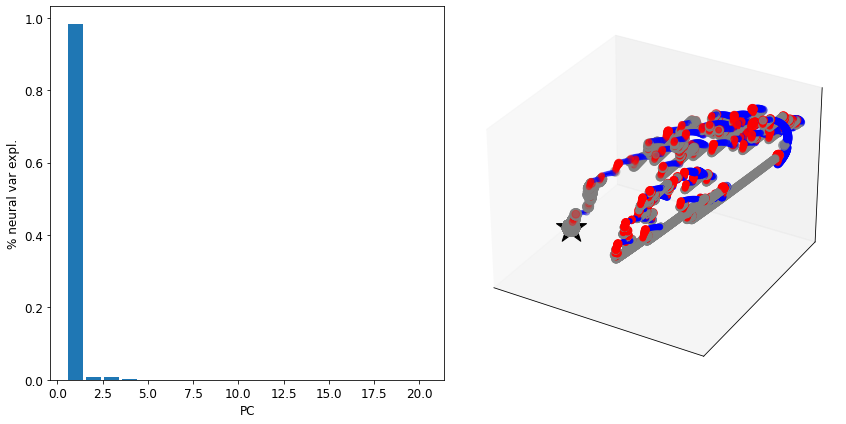

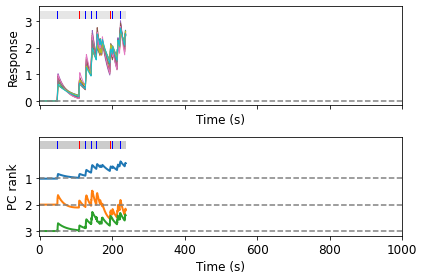

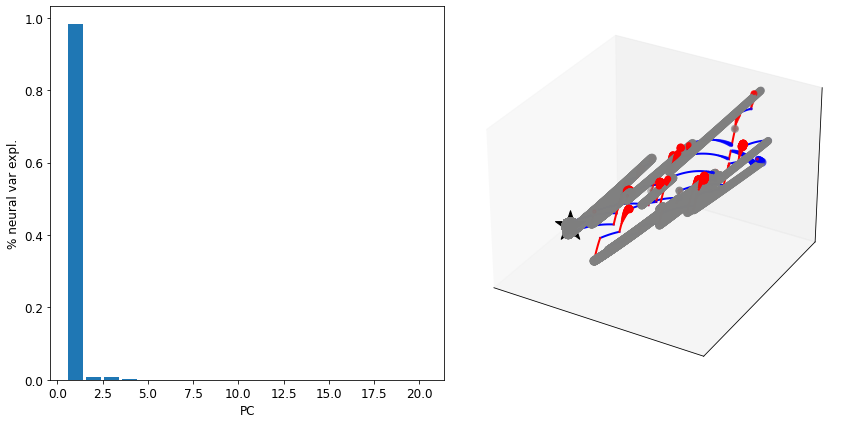

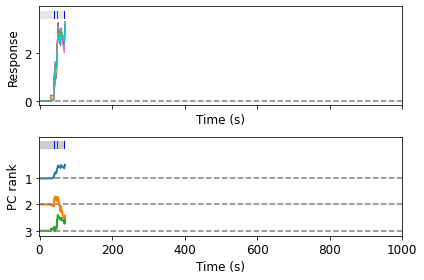

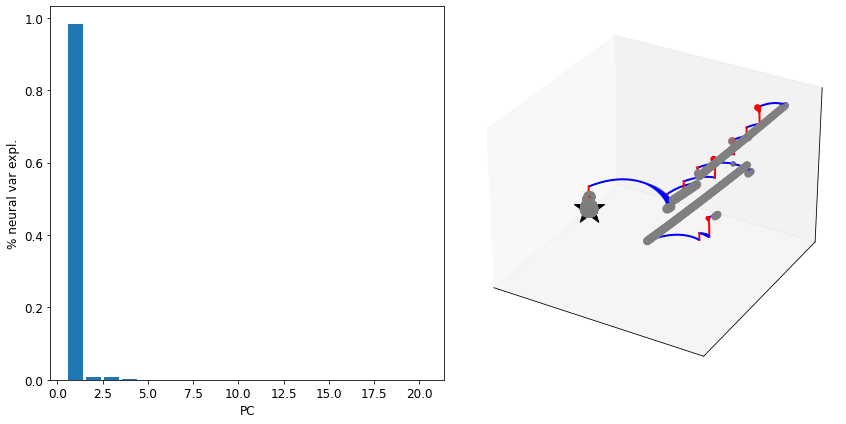

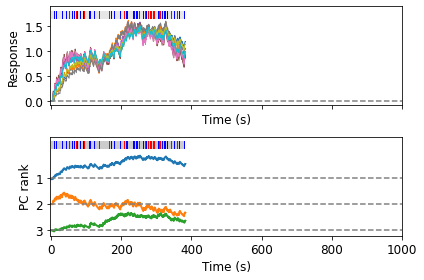

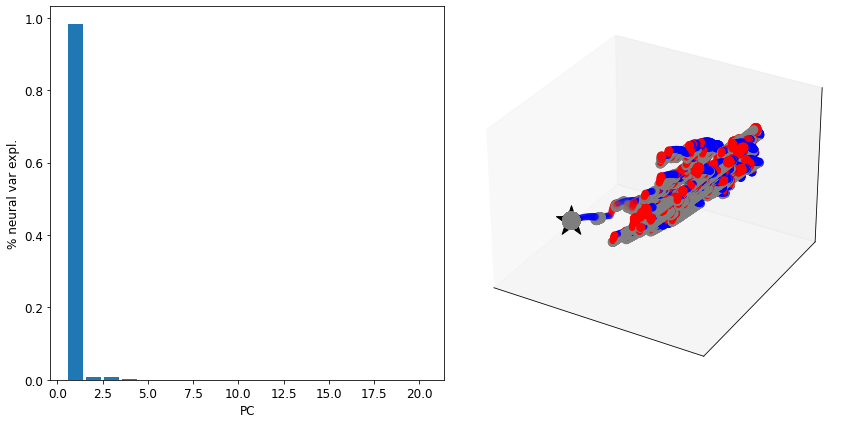

In [8]:
itrs_t_starts_t_ends = [
    # (0, -2, 130),
    # (7, -2, 75),
    (0, -2, 200),
    (1, -2, 1000),
    (2, -2, 1000),
    (3, -2, 1000),
    # (4, -2, 1000),
    # (5, -2, 1000),
    # (6, -2, 500),
    # (7, -2, 1000),
    # (83, -2, 1000),
]

for itr, t_start, t_end in itrs_t_starts_t_ends:
    df_tr = df_trs[itr]
    t = np.array(df_tr['T'])
    
    i_s = np.array(df_tr['S']).astype(float)
    i_p = np.array(df_tr['P'] | df_tr['F']).astype(float)
    
    b = np.zeros(len(t), dtype=int)
    b[i_s == 1] = 1
    b[i_p == 1] = 2

    # simulate population response
    rs = rs_20_mas[itr]
    for cnrn in range(N):
        rs[:, cnrn] /= np.mean(rs[:, cnrn])
    
    # project onto top PCs
    rs_pc = pca_20.transform(rs)
    
    fig, axs = plt.subplots(2, 1, figsize=(6, 4), tight_layout=True, sharex=True)
    
    # plot neural responses and song
    axs[0].plot(t, rs[:, :10], lw=1)
    axs[0].axhline(0, color='gray', ls='--')
    plot_b(axs[0], t, b, [t[0], t[-1]+DT, rs.max(), 1.1*rs.max()], c=[(.9, .9, .9), 'b', 'r'])
    set_plot(axs[0], x_lim=(t_start, t_end), x_label='Time (s)', y_label='Response')
    
    npc_plot = 3
    y_ticks = []
    for cpc in range(npc_plot):
        prj_pc = rs_pc[:, cpc]
        prj_pc = prj_pc/np.std(prj_pc)
        y_off = -cpc*5
        axs[1].plot(t, prj_pc + y_off, lw=2)
        axs[1].axhline(y_off, color='gray', ls='--')
        
        y_ticks.append(y_off)
        
    plot_b(axs[1], t, b, [t[0], t[-1]+DT, 5.5, 7], c=[(.8, .8, .8), 'b', 'r'])
    set_plot(axs[1], y_ticks=y_ticks, y_tick_labels=np.arange(npc_plot)+1, x_lim=(t_start, t_end), x_label='Time (s)', y_label='PC rank')
    
    fig.savefig(f'ms/2_fast_ad_slow_int_song_itr_{itr}.svg')
    
    # plot neural trajectory in PCA space
    
    fig = plt.figure(figsize=(12, 6), tight_layout=True)
    axs = [fig.add_subplot(1, 2, 1), fig.add_subplot(1, 2, 2, projection='3d')]
    
    axs[0].bar(1 + np.arange(N), pca_20.explained_variance_ratio_)
    set_plot(axs[0], x_label='PC', y_label='% neural var expl.')
    
    
    mt = (t_start <= t) & (t < t_end)
    trj_3d(axs[1], t[mt], rs_pc[mt, 0], rs_pc[mt, 1], rs_pc[mt, 2], b[mt], s_max=300, v_max=2, gam=.1)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[1].set_zticks([])
    axs[1].scatter(rs_pc[0, 0], rs_pc[0, 1], rs_pc[0, 2], marker='*', c='k', s=1000)
    set_plot(axs[1])
    
    # fig.savefig(f'ms/fig_2_fast_a_slow_r_song_trj_itr_{itr}.svg')